In [1]:
%run 'ks01_Data_import.ipynb'
notebook_prefix = 'ks17'
image_counter = Counter()

/Users/karen/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/karen/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


### Lucas files

In [44]:
species_distances = pd.read_csv(files_dump_folder + 'evolutionary_distance_vs_weights/' + 'HIS3_alignment_500species.fas.tab.pairwise.proportion.txt',)
alignment_569sp = pd.read_table(files_dump_folder + 'evolutionary_distance_vs_weights/' + 'HIS3_alignment_500species.fas.tsv')
alignment_569sp.set_index('organism', inplace=True)

Scer_name = 'sp|P06633|HIS7_YEAST_Imidazoleglycerol-phosphate_dehydratase_OSSaccharomyces_cerevisiae_(strain_ATCC_204508_/_S288c)_GNHIS3_PE1_SV2'
Scer_aligned_seq = alignment_569sp.loc[Scer_name].aligned_seq

In [45]:
def remove_gaps(seq):
    return ''.join([c for c in seq if c != '-'])

In [46]:
Scer_name_distances = 'sp|P06633|HIS7 YEAST Imidazoleglycerol-phosphate dehydratase OSSaccharomyces cerevisiae (strain ATCC 204508 / S288c) GNHIS3 PE1 SV2'

def figure_other_organism(df):
    if df['organism1'] == Scer_name_distances:
        return df['organism2']
    elif df['organism2'] == Scer_name_distances:
        return df['organism1']
    else:
        return None

Scer_distances = species_distances[(species_distances['organism1'] == Scer_name_distances) | \
                                   (species_distances['organism2'] == Scer_name_distances)].copy()

Scer_distances['other_organism'] = Scer_distances.apply(figure_other_organism, axis=1)
assert len(Scer_distances[Scer_distances['other_organism'] == Scer_name_distances]) == 0
Scer_distances[:2]

,organism1,organism2,distance,other_organism
87571,sp|Q9S5G5|HIS7 ECO57 Histidine biosynthesis bi...,sp|P06633|HIS7 YEAST Imidazoleglycerol-phospha...,0.545,sp|Q9S5G5|HIS7 ECO57 Histidine biosynthesis bi...
87572,sp|P06987|HIS7 ECOLI Histidine biosynthesis bi...,sp|P06633|HIS7 YEAST Imidazoleglycerol-phospha...,0.545,sp|P06987|HIS7 ECOLI Histidine biosynthesis bi...


In [47]:
all_natural_unique_single_mutations = sorted(list(set(flatten_list(natural_unique_single_mutations.values()))), key=lambda s: int(s[:-1]))
all_natural_unique_single_mutations = [get_full_mutation(m) for m in all_natural_unique_single_mutations]

Check this function


In [48]:
def get_position_in_alignment(aligned_seq, position_in_Scer_Uniprot):
    counter = 0
    for index, aa in enumerate(aligned_seq):
        if aa != '-' :
            counter += 1
        if counter == position_in_Scer_Uniprot+1:
            break
    try: 
        assert Scer_aligned_seq[index] == Scer_Uniprot[position_in_Scer_Uniprot]
    except:
        print 'Position in Uniprot:', position_in_Scer_Uniprot
        print 'Position in alignment:', index
        print 'Char in aligned Scer seq:', Scer_aligned_seq[index]
        print 'Char in Uniprot Scer seq:', Scer_Uniprot[position_in_Scer_Uniprot]

        print 'Char in aligned Scer seq:', Scer_aligned_seq[:index]
        print 'Char in Uniprot Scer seq:', Scer_Uniprot[:position_in_Scer_Uniprot]
        assert Scer_aligned_seq[index] == Scer_Uniprot[position_in_Scer_Uniprot]
    return index

evolutionary_distances = OrderedDict()
for mutation in all_natural_unique_single_mutations:
    position_Scer = int(mutation[1:-1])-1
    position_in_alignment = get_position_in_alignment(Scer_aligned_seq, position_Scer)
    Scer_distances['aa_state'] = Scer_distances['other_organism'].apply(
        lambda s: alignment_569sp.loc['_'.join(s.split())]['aligned_seq'][position_in_alignment])
    distance_values = [Scer_distances[Scer_distances['aa_state'] == mutation[-1]]['distance'].values]

    if len(distance_values[0]) == 0:
        print mutation, position_Scer, position_in_alignment
        print Scer_aligned_seq[position_in_alignment], Scer_Uniprot[position_Scer]
        print distance_values
        print
        break
    evolutionary_distances[mutation] = distance_values

### Weights

In [49]:
# Relative >>> absolute position
position_translation = pd.read_table(files_dump_folder + 'position_translation.csv')
position_translation.set_index('relative_position', inplace=True)

def get_absolute_position(segment_short, relative_position):
    return int(position_translation.iloc[int(relative_position)][segment_short])

In [50]:
weights_folder = os.path.join(analysis_folder, 'Katya', 'NN', 'weights', '')
weights = OrderedDict()
for segment in data:
    weights[segment] = pd.read_csv(weights_folder + '%s.csv' %segment.split('_')[0])
    weights[segment]['mut_list_Scer'] = weights[segment]['Unnamed: 0'].apply(lambda s: str(get_absolute_position(segment.split('_')[0], int(s[:-1]))) + s[-1])
    weights[segment].set_index('mut_list_Scer', inplace=True)

mutations_weights = OrderedDict()
for mutation in all_natural_unique_single_mutations:
#     print mutation
    for segment in weights:
        try:
            weight = weights[segment].loc[mutation[1:]].weight
            mutations_weights[mutation] = weight
#             print weight
#             print
        except KeyError:
            pass
print len(mutations_weights)

238


### ddG

In [51]:
%run 'ks20_Read_ddG.ipynb'


Variables: 
- predicted_ddG:		Pandas DataFrame with all calculated ddG (single, double and triple mutants (?)),
- predicted_doubles:		doubles only (Pandas DataFrame),
- predicted_singles:		singles only (Pandas DataFrame),
- get_ddG:			function that returns predicted ddG for a genotype
- by_position_mean_ddG:		mean ddG value at each position,
- by_position_var_ddG:		variance of predicted ddG at each position.



### Merging

In [52]:
evol_dist = pd.DataFrame.from_dict(evolutionary_distances, orient='index')
evol_dist.columns = ['distances']
neural_weights = pd.DataFrame.from_dict(mutations_weights, orient='index')
neural_weights.columns = ['weight']
merged = evol_dist.merge(neural_weights, how='inner', left_index=True, right_index=True)
# merged.drop('Unnamed: 0', inplace=True, axis=1)
merged['dist_min'] = merged['distances'].apply(np.min)
merged['dist_mean'] = merged['distances'].apply(np.mean)
merged['dist_median'] = merged['distances'].apply(np.median)
merged['dist_3min'] = merged['distances'].apply(lambda l: np.mean(sorted(l)[:min(len(l), 3)]))
merged['dist_5min'] = merged['distances'].apply(lambda l: np.mean(sorted(l)[:min(len(l), 5)]))
merged['dist_Xmin'] = merged['distances'].apply(lambda l: np.mean(sorted(l)[:min(len(l), 8)]))

merged = merged.reset_index().merge(predicted_singles, how='inner', left_on='index', right_on='mut_list_Scer_full')
merged.set_index('index', inplace=True)

In [84]:
%run 'ks21_Read_impacts_of_mutations.ipynb'


Variables: 

- fit_dict: a dictionary, keys are mutations and values are pandas.Series of fitness impacts in all backgrounds. 



### Plotting and fitting

In [60]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

def linear_function(x, A, B): # this is your 'straight line' y=f(x)
    return A*x + B

def exponential_function(x, a, b, c):
    return a * np.exp(-b * x) + c

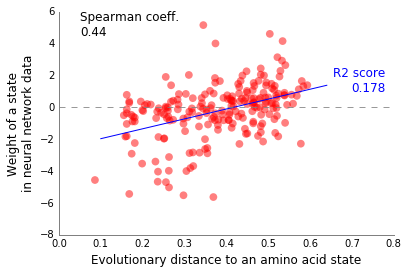

In [74]:
x = 'dist_5min'
y = 'weight'

plot_better(grid='', width=6, height=4)

linear_color = 'blue'
linear_fit = curve_fit(linear_function, merged[x], merged[y])[0]
A,B = linear_fit
line_x = np.arange(0.1,0.65, 0.01)
line_y = [linear_function(v, A, B) for v in line_x]
linear_r2_score = r2_score(merged[y].values, [linear_function(v, A, B) for v in merged[x].values])
plt.plot(line_x, line_y, color=linear_color)
plt.text(0.78, 1, 'R2 score\n%.3f' %linear_r2_score, fontsize=12, color=linear_color, ha='right')

# exp_color = 'orange'
# p0=[merged[y].values.max() - merged[y].values.min(), 1, merged[y].values.min()]
# exponential_fit = curve_fit(exponential_function, merged[x], merged[y], maxfev=5000, p0=p0)[0]
# a,b,c = exponential_fit
# line_x = np.arange(0.1,0.65, 0.01)
# line_y = [exponential_function(v, a, b, c) for v in line_x]
# plt.plot(line_x, line_y, color=exp_color)
# exponential_r2_score = r2_score(merged[y].values, [exponential_function(v, a, b, c) for v in merged[x].values])
# plt.text(0.65, 2, 'Exp. R2 score: %.6f' %exponential_r2_score, fontsize=12, color=exp_color)

plt.scatter(merged[x], merged[y], edgecolor='none', alpha=0.5, color='red', s=60)
statistics = stats.spearmanr(merged[x], merged[y])
statistics_kendal = stats.kendalltau(merged[x], merged[y])
plt.xlabel('Evolutionary distance to an amino acid state', fontsize=12)
plt.ylabel('Weight of a state\nin neural network data', fontsize=12)
plt.axhline(0., color='gray', ls='--', alpha=0.8)
# plt.title('Evolution vs. neural network' + '\nSpearman coeff: %.2f, p-value=%.8f' %(statistics[0], statistics[1]))
plt.text(0.05, 4.5, 'Spearman coeff.\n%.2f' %(statistics[0]), fontsize=12)
plt.xlim(0,0.8)
plt.savefig(figures_folder + 'Evolution_vs_neural_network.pdf')

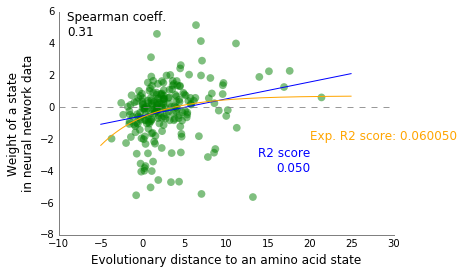

In [82]:
x = 'ddG'
y = 'weight'

plot_better(grid='', width=6, height=4)

linear_color = 'blue'
linear_fit = curve_fit(linear_function, merged[x], merged[y])[0]
A,B = linear_fit
line_x = np.arange(-5,25, 0.1)
line_y = [linear_function(v, A, B) for v in line_x]
linear_r2_score = r2_score(merged[y].values, [linear_function(v, A, B) for v in merged[x].values])
plt.plot(line_x, line_y, color=linear_color)
plt.text(20, -4, 'R2 score\n%.3f' %linear_r2_score, fontsize=12, color=linear_color, ha='right')

exp_color = 'orange'
p0=[merged[y].values.max() - merged[y].values.min(), 1, merged[y].values.min()]
exponential_fit = curve_fit(exponential_function, merged[x], merged[y], maxfev=5000, p0=p0)[0]
a,b,c = exponential_fit

line_y = [exponential_function(v, a, b, c) for v in line_x]
plt.plot(line_x, line_y, color=exp_color)
exponential_r2_score = r2_score(merged[y].values, [exponential_function(v, a, b, c) for v in merged[x].values])
plt.text(20, -2, 'Exp. R2 score: %.6f' %exponential_r2_score, fontsize=12, color=exp_color)

plt.scatter(merged[x], merged[y], edgecolor='none', alpha=0.5, color='green', s=60)
statistics = stats.spearmanr(merged[x], merged[y])
statistics_kendal = stats.kendalltau(merged[x], merged[y])
plt.xlabel('Evolutionary distance to an amino acid state', fontsize=12)
plt.ylabel('Weight of a state\nin neural network data', fontsize=12)
plt.axhline(0., color='gray', ls='--', alpha=0.8)
# plt.title('Evolution vs. neural network' + '\nSpearman coeff: %.2f, p-value=%.8f' %(statistics[0], statistics[1]))

plt.text(-9, 4.5, 'Spearman coeff.\n%.2f' %(statistics[0]), fontsize=12)
# plt.xlim(0,0.8)
plt.savefig(figures_folder + 'ddG_vs_neural_network.pdf')